# The Perceptron
## Hand written digit classifier
### Itamar Yuran
#### A perceptron is a fundamental building block in artificial neural networks, serving as a simple binary linear classifier. Developed by Frank Rosenblatt in 1957, a perceptron takes multiple binary inputs, applies weights to them, sums the results, and passes the sum through an activation function to produce an output.

#### Mathematically, the perceptron output (y) is determined by the weighted sum of inputs (x) and a bias term (b)
#### The weight of each input is determined as such:
#### Initial weight vector is set to be the zero vector, with a length of the input vectur, in our case 785 (28x28 pixels per image + bias term). the classification is determined by the sign of the dot product of the weight vector and each input, 1 being True and -1 False. for every misclassified instance in the training set, we update the weight vector according the formula:
#### W(t+1) = W(t) + X(t)Y(t)
#### W being the weight vector of iteration t, X being the t input and Y being the corresponding t label 
#### Worth Mentioning, that a perceptron will only reach 100% accuracy in cases in which the data is linearly separable. this is why in our case (which the data isnt linearly separable) we use the pocket algorithm. This one, is keeping the best weight vector we had and in case the pla algorithm doesnt converge, after several iterations, stops the algorithm and returns the best weight vector we had, meaning, the one who classified correctly the biggest amount of instances

#### In this assignment I implemented the perceptron from scratch using numpy. The data I used is brought from the mnist data set, containing 70000 hand written digits in 28x28 pixel images, and tagged with the real digit each image represents. 


In [175]:
# Importing the necessary libraries

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA


In [176]:
# Fetching the data

mnist = fetch_openml('mnist_784', version=1)

/Users/itamaryuran/.conda/envs/maman22/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [177]:
# Dividing the data to training set and test set

train_size = 60000
test_size = 10000

X, y = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=33)


In [178]:
# Preprocessing the data - converting to Numpy arrays, making sure the data representation is as we need
# We normalise the input data values from range 0-255 to be in range 0-1
# In addition we add the bias term to each one of the inputs
# From here on we use the notations:
# x --->  train set
# y --->  train label
# x_t ->  test set
# y_t ->  test label

X_train = np.array([np.array(x) for x in X_train.values])
X_test = np.array([np.array(x) for x in X_test.values])

X_train = X_train.astype(np.uint8)
X_test = X_test.astype(np.uint8)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

x = X_train.copy()
y = y_train.copy()
x = x.astype(float)
x = x / 255.0
x = np.insert(x, 0, 1, axis=1)
y = y.to_numpy()

x_t = X_test.copy()
y_t = y_test.copy()
x_t = x_t.astype(float)
x_t = x_t / 255.0
x_t = np.insert(x_t, 0, 1, axis=1)
y_t = y_t.to_numpy()


#### Each "input" is as I said an image of a digit. We will represent these in one single vector containing a value for every pixel of the image (and a bias term). 
#### The raw data we work on, looks like this:

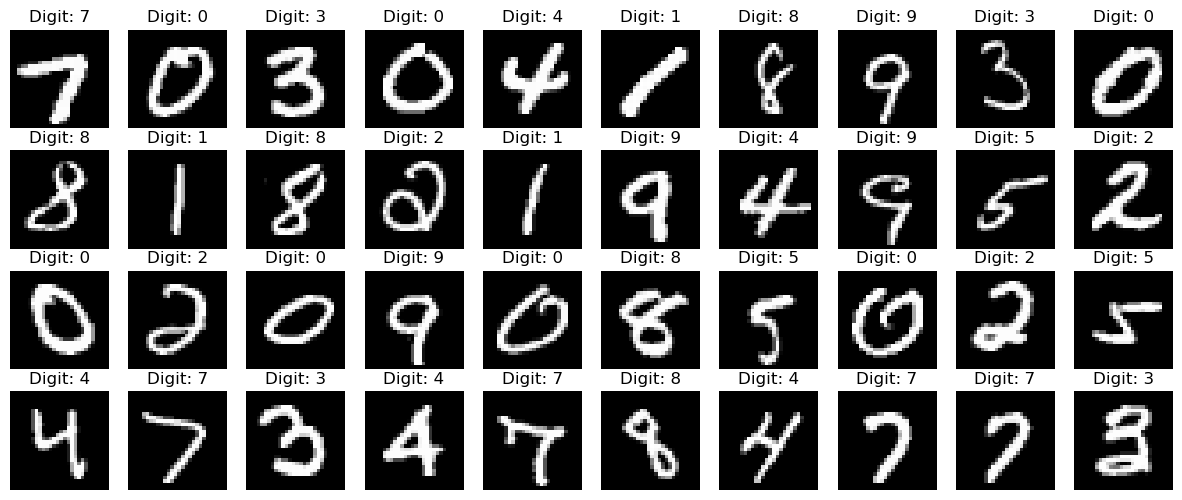

In [179]:
fig, axes = plt.subplots(4, 10, figsize=(15, 6))

for i in range(40):
    axes[i // 10, i % 10].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[i // 10, i % 10].set_title('Digit: {}'.format(y_train.iloc[i]))
    axes[i // 10, i % 10].axis('off')

plt.show()

In [180]:
# Quick check that the data is shapes as we pleased

print("training set shape: ",x.shape)
print("training label shape: ",y.shape)
print("test set shape: ",x_t.shape)
print("test label shape: ",y_t.shape)

training set shape:  (60000, 785)
training label shape:  (60000,)
test set shape:  (10000, 785)
test label shape:  (10000,)


#### Here it is, the heart of the assignment, this is how I implemented the perceptron class


In [181]:
class Perceptron:
    
    # The perceptron is initialised with the digit it needs to classify, the training set and label set.
    # Weight vector initialised to 0, and misclassified to the length of the set
    # The labels are converted to 1/-1, 1 being the number this perceptron needs to classify 
    
    def __init__(self, number, X_train, y_train, max_epochs = 30):
        self.number = number
        self.weight_vector = np.zeros(785)
        self.X = X_train.copy()
        self.y = y_train.copy()
        self.y = [1 if num == self.number else -1 for num in self.y]
        self.pocket_weight_vector = self.weight_vector.copy()
        self.pocket_misclassified = len(self.y)
        self.loss = []
        self.max_epochs = max_epochs
        
    # Update function. missclassified instances are being multyplied by the label and added to the weight vector   
        
    def update_weight(self, index):
        self.weight_vector +=  (self.y[index] * self.X[index])

    # Classification. The dot product between the weight vector and the input, multiplied by the "sigh"
    # or label of the instance. Positive result means correct classification, and vice versa.
    
    def classify(self, index):
        num = np.dot(self.X[index], self.weight_vector) * self.y[index]
        return num > 0

    # Training the perceptron. Max epochs stands for the number of iterations over the data before the
    # algorithm stops and returns the best vector it had already achive
    # We check for each instance whether its correctly classified. In case its not we update weights accordingly
    # After each epoch we check how many misclassified instances we have. in case there are less than what we 
    # already had, current weight vector is is saved in the module as pocket weight vector.
    
    def train(self):
        for epoch in range(self.max_epochs):
            miss = 0
            for index in range(len(self.y)):
                if not self.classify(index):
                    self.update_weight(index)
                    miss +=1

            current_misclassified = miss
            self.loss.append(current_misclassified/len(self.y))

            if current_misclassified < self.pocket_misclassified:
                self.pocket_weight_vector = self.weight_vector.copy()
                self.pocket_misclassified = current_misclassified
            
    
    # After finishing the training we obtaind our desired weight vector, and use it to classify test instances
    
    def predict(self, X_test):
        predictions = []
        for index in range(len(X_test)):
            num = np.sign(np.dot(X_test[index], self.weight_vector))
            predictions.append(num)
        return predictions
        
    # This function checks how many misclassified instances we have after a given iteration.
    
    def count_misclassified(self):
        return sum(1 for index in range(len(self.y)) if not self.classify(index))


### Let's see how well did our model.
#### For each digit we will now print the confusion matrix. In this case its a 2x2 matrix that looks like this
#### [true positive, false positive]                                                                                                                                                                                    [false negative, true negativ
#### true positive meaning the instances that were classified as target class (1) , and they really are
#### true negative meaning the instances that were classified as not target class (-1) , and they really are 
#### false positive meaning the instances that were classified as target class (1), but they aren't (-1)
#### false negative meaning the instances that were classified as not target class (-1) , but they aren't (1)

#### accuray stands for tp+tn / tp+tn+fp+fn - only the right classifications out of all classifications
#### sensitivity stands for the true positive rate - meaning the accuracy of the model when it classified instance is target class
#### selectivity stands for the true negative rate - meaning the accuracy of the model when it classified instance is not  target class

In [182]:
losses = []
for class_label in range(10):
    
    labels = [1 if num == class_label else -1 for num in y_t.copy()]
    
    binary_perceptron = Perceptron(class_label, x, y,20)
    binary_perceptron.train()
    y_pred_binary = binary_perceptron.predict(x_t)
    losses.append(binary_perceptron.loss)
    
    cm_binary = confusion_matrix(labels, y_pred_binary, labels=[1, -1])
    accuracy_binary = np.sum(np.diagonal(cm_binary))/np.sum(cm_binary)
    sensitivity_binary = cm_binary[0, 0] / np.sum(cm_binary[0, :])
    selectivity_binary = cm_binary[1, 1] / np.sum(cm_binary[1, :])

    print(f"Metrics for Binary Perceptron (Digit {class_label}):")
    print(cm_binary)
    print(f"Accuracy:    {accuracy_binary * 100:.2f}%")
    print(f"Sensitivity: {sensitivity_binary * 100:.2f}%")
    print(f"Selectivity: {selectivity_binary * 100:.2f}%")
    print("*" * 60)


Metrics for Binary Perceptron (Digit 0):
[[ 901   50]
 [  45 9004]]
Accuracy:    99.05%
Sensitivity: 94.74%
Selectivity: 99.50%
************************************************************
Metrics for Binary Perceptron (Digit 1):
[[1141   59]
 [  33 8767]]
Accuracy:    99.08%
Sensitivity: 95.08%
Selectivity: 99.62%
************************************************************
Metrics for Binary Perceptron (Digit 2):
[[ 686  315]
 [  28 8971]]
Accuracy:    96.57%
Sensitivity: 68.53%
Selectivity: 99.69%
************************************************************
Metrics for Binary Perceptron (Digit 3):
[[ 897  106]
 [ 513 8484]]
Accuracy:    93.81%
Sensitivity: 89.43%
Selectivity: 94.30%
************************************************************
Metrics for Binary Perceptron (Digit 4):
[[ 817   95]
 [ 134 8954]]
Accuracy:    97.71%
Sensitivity: 89.58%
Selectivity: 98.53%
************************************************************
Metrics for Binary Perceptron (Digit 5):
[[ 629  262]
 

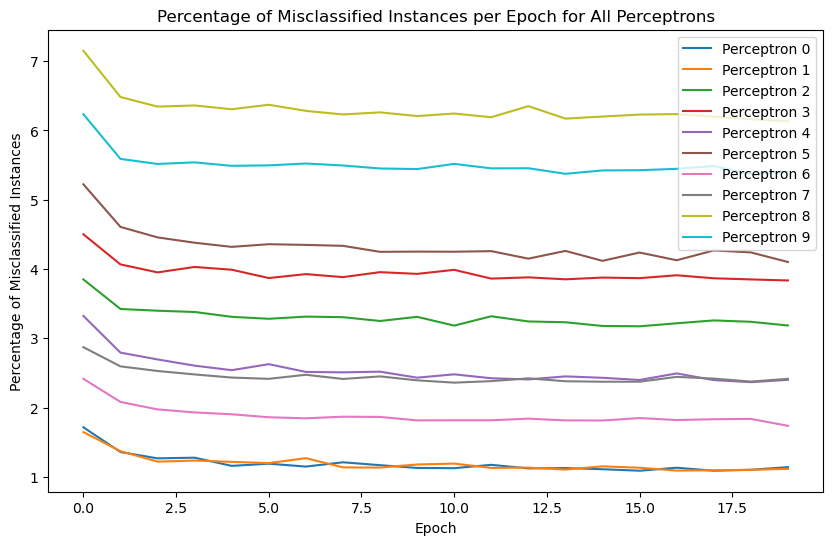

In [183]:
plt.figure(figsize=(10, 6))
for i, perceptron_loss in enumerate(losses):
    percentage_loss = [loss * 100 for loss in perceptron_loss]
    plt.plot(range(len(percentage_loss)), percentage_loss, label=f'Perceptron {i}')

plt.xlabel('Epoch')
plt.ylabel('Percentage of Misclassified Instances')
plt.title('Percentage of Misclassified Instances per Epoch for All Perceptrons')
plt.legend()
plt.show()

#### Let us now extend the binary perceptron class we wrote, to a multy perceptron.
#### This class will contain 10 perceptron, eace one classifies one digit out of the rest. 
#### eventually we'll end up with 10 different weight vectors, one for each digit. in order to determine which digit is represented by a given input, we will choose the digit represented by the weight vector that gets us the maximum dot product, with that given instance.
####



In [184]:
class MultiPerceptron:
    
    # For the multi perceptron, we initiate an array of ten binary perceptrons. 
    # Each gets a copy of the training set and the digit it needs to classify.
    
    def __init__(self, numOfClasses, X_train,y_train,epoch):
        self.numOfClasses = numOfClasses
        self.X = X_train.copy()
        self.y = y_train.copy()
        self.perceptrons = [Perceptron(number,self.X,self.y,epoch) for number in range(numOfClasses)]
        self.vectors = np.array([])
    
    # We train each perceptron separately over his target digit and eventually we hold an 
    # array of all the perceptrons weight vectors
    
    def train(self):
        vector_list = []
        for p in self.perceptrons:
            p.train()
            vector_list.append(p.weight_vector)
        self.vectors = np.array(vector_list)

    # According to the weight vectors we got in the training part, we predict each digit by choosing the perceptron 
    # that had the maximum product between its weight vector and the instance we classify.
    
    def predict(self, X_test):
        predictions =[]
        for x in X_test:
            x_reshaped = x.reshape(-1, 1)
            argmax = np.argmax(np.dot(self.vectors, x_reshaped))
            predictions.append(argmax)
        return predictions

    

In [185]:
P = MultiPerceptron(10,x,y,20)
P.train()
y_pred = P.predict(x_t)
cm = confusion_matrix(y_t, y_pred, labels=range(10))

### Similarly to the conrusion matrix for each digit, that is the model's c.m.
#### As you can see it differs of course by the num of instances. In this c.m we dont have true negative values, here every row represents one class. the values that sit on the diagonal are the true positive classifications. other then that, every value on a cell i,j represents the amount of i tegged instances that were classified as j
#### Here accuracy is the sum of the diagonal divided by sum of all the matrix
#### TP is for each class, the value on the diagonal, its percents version, is the value on the diagonal divided by the sum of that row
#### FN is the sum of each row minus the diagonal's value
#### FP is the sum of each column minus the diagonal's value



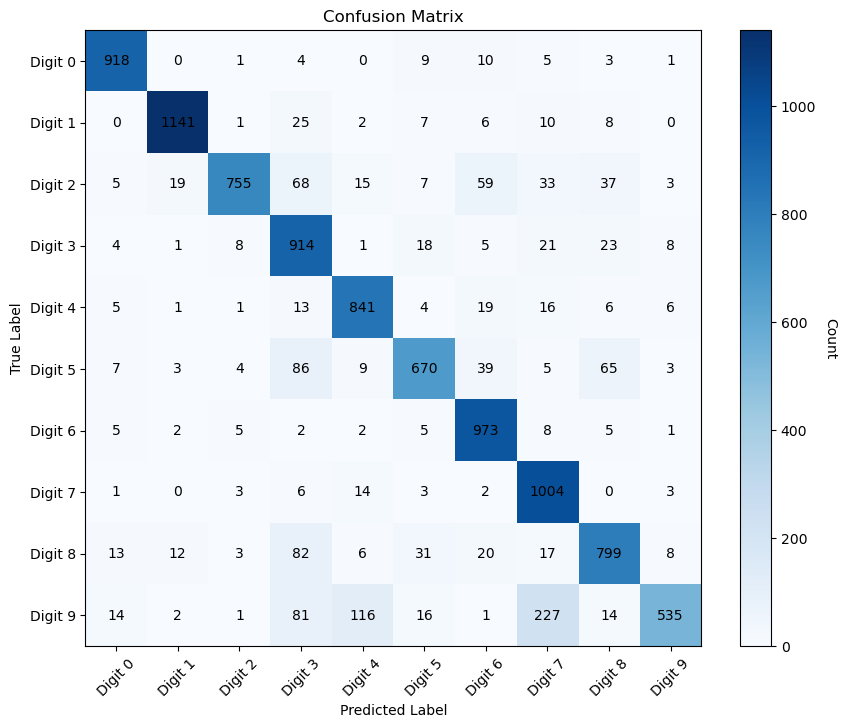

In [186]:

class_labels = [f'Digit {i}' for i in range(10)]
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
cbar = plt.colorbar()
cbar.set_label('Count', rotation=270, labelpad=15)
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
plt.yticks(np.arange(len(class_labels)), class_labels)
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()


In [187]:
TP = np.diagonal(cm)
TP_percent = TP / np.sum(cm, axis=1)
FP = np.sum(cm, axis=0) - TP
FP_percent = FP / np.sum(cm, axis=1)
FN = np.sum(cm, axis=1) - TP
FN_percent = FN / np.sum(cm, axis=1)


rounded_TP = np.round(TP_percent * 100, decimals=2) 
rounded_FP = np.round(FP_percent * 100, decimals=2) 
rounded_FN = np.round(FN_percent * 100, decimals=2) 


print(f"True Positives:              {TP}")
print(f"True Positives (%):          {rounded_TP}\n")
print(f"False Positives:             {FP}")
print(f"False Positives (%):         {rounded_FP}\n")
print(f"False Negatives:             {FN}")
print(f"False Negatives (%):         {rounded_FN}")
print(f"Accuracy:                    {accuracy * 100:.1f}%")



True Positives:              [ 918 1141  755  914  841  670  973 1004  799  535]
True Positives (%):          [96.53 95.08 75.42 91.13 92.21 75.2  96.53 96.91 80.63 53.13]

False Positives:             [ 54  40  27 367 165 100 161 342 161  33]
False Positives (%):         [ 5.68  3.33  2.7  36.59 18.09 11.22 15.97 33.01 16.25  3.28]

False Negatives:             [ 33  59 246  89  71 221  35  32 192 472]
False Negatives (%):         [ 3.47  4.92 24.58  8.87  7.79 24.8   3.47  3.09 19.37 46.87]
Accuracy:                    87.6%


### Let us now take a look over the classifications.
#### In the plot below there are 100 instances from the test set, above each one we have the models prediction to that instance as well as that instance's label

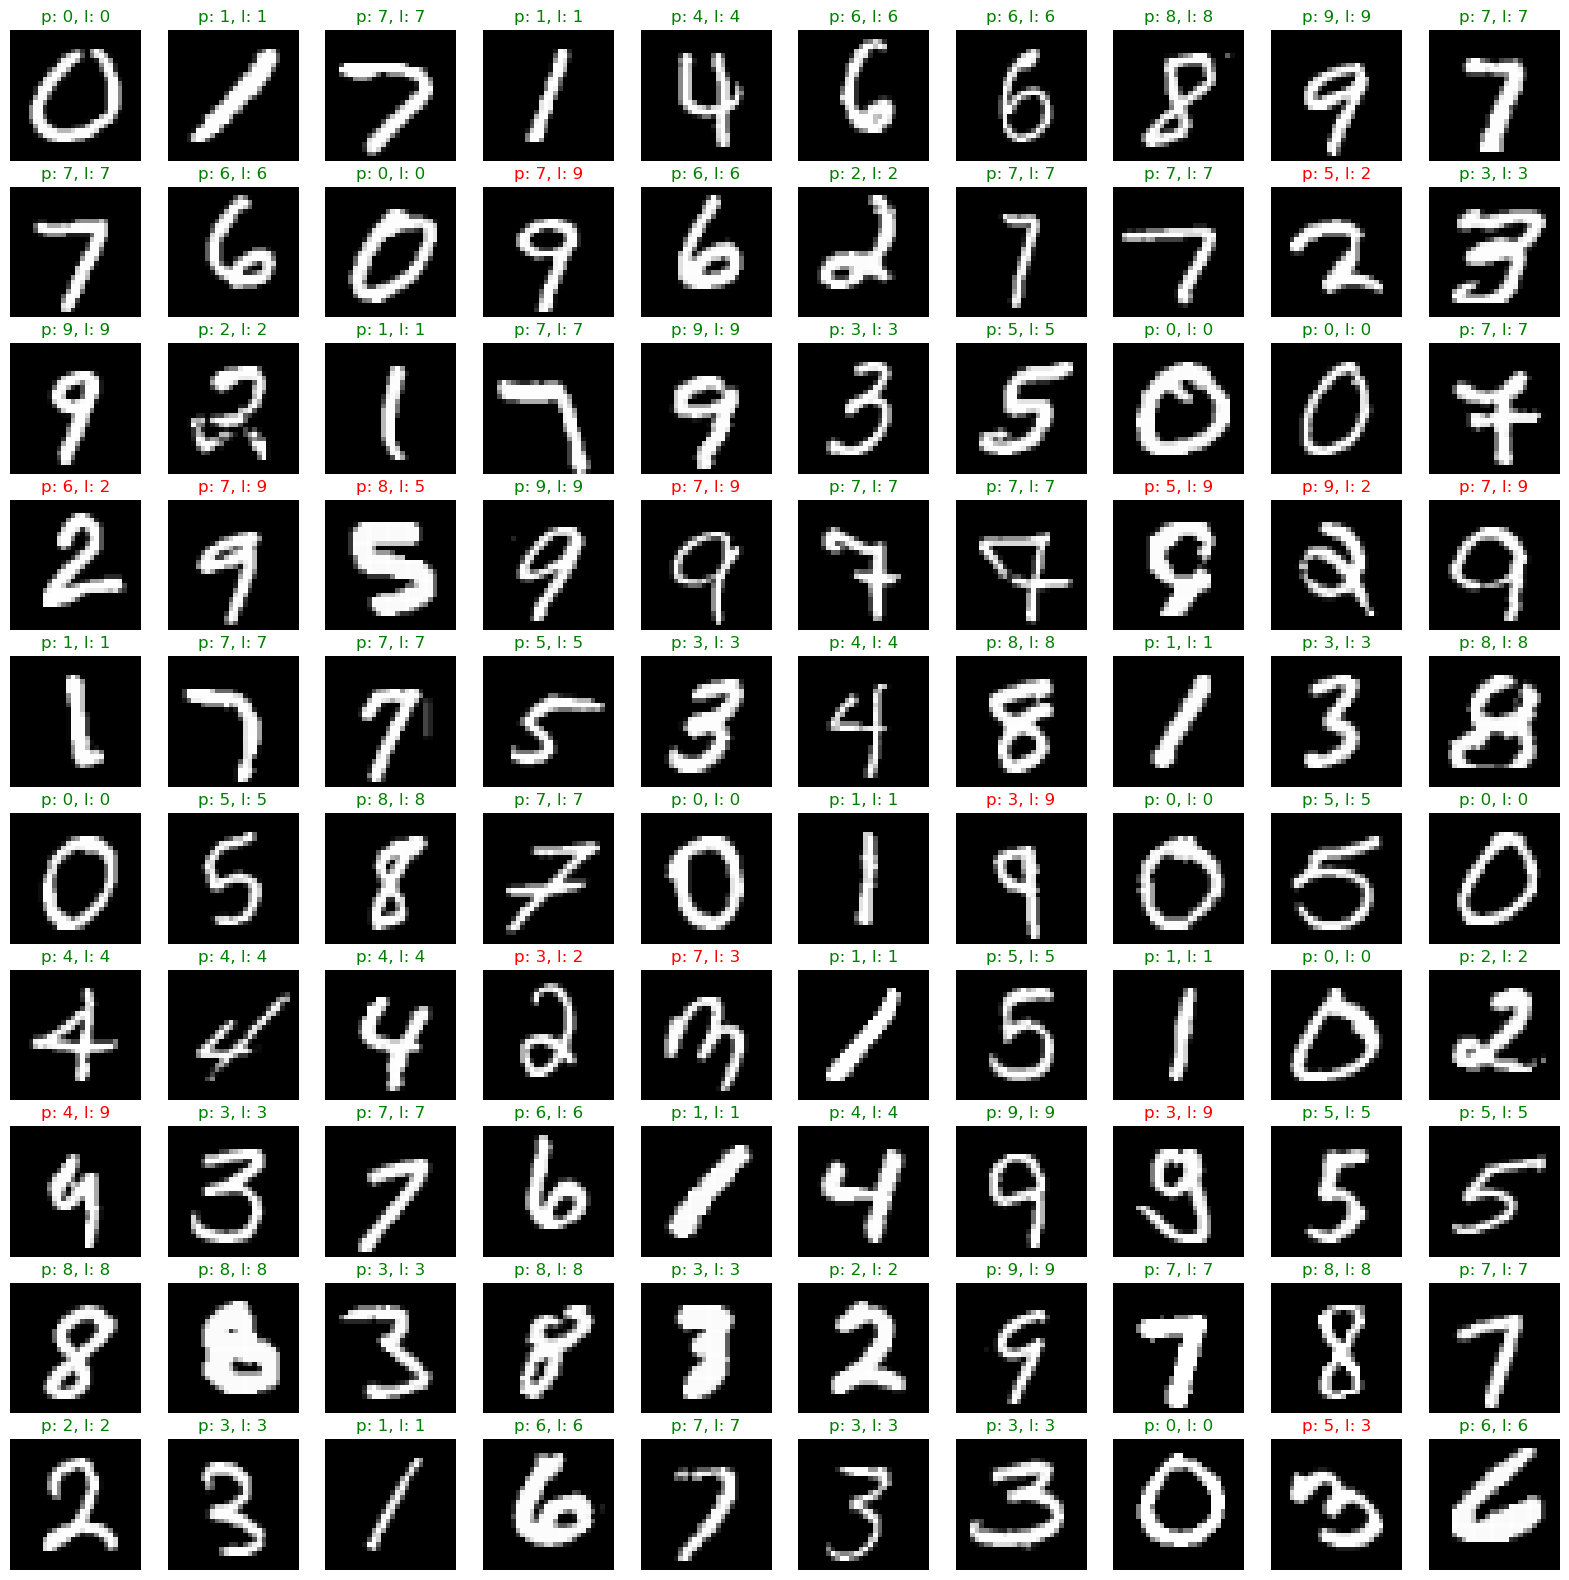

In [188]:
miss = 0 # for the next cell
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

for i in range(100):
    img = X_test[i].reshape(28, 28)
    pred_label = y_pred[i]
    true_label = y_t[i]
    if pred_label == true_label:
        color = 'green' 
    else:
        color = 'red'
        miss = i

    axes[i // 10, i % 10].imshow(img, cmap='gray')
    axes[i // 10, i % 10].set_title('p: {}, l: {}'.format(pred_label, true_label), color=color)
    axes[i // 10, i % 10].axis('off')

plt.savefig("classification")
plt.show()


## An interesting plot would be the algorithm's desicion in action. In the following cell there is a digram of the dot product between an input and each weight vector, for the example i chose a misclassified instance 

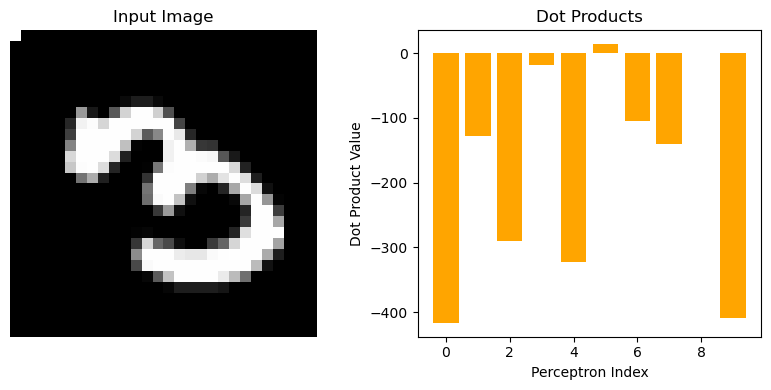

In [189]:
example_index = miss

input_image = x_t[example_index, :-1].reshape(28, 28)

dot_products = np.dot(P.vectors[:, :-1], x_t[example_index, :-1])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.bar(range(10), dot_products, color='orange')
plt.title('Dot Products')
plt.xlabel('Perceptron Index')
plt.ylabel('Dot Product Value')

plt.tight_layout()
plt.show()


### Now, I would like us to take a look on whats going on inside the algorithm. 
#### In the plots below we can see the weight vectors. green color stands for a positiv weight while red is negative. In general, the darker the color is, the more signifhcant this vealue for the algorithm's desicion

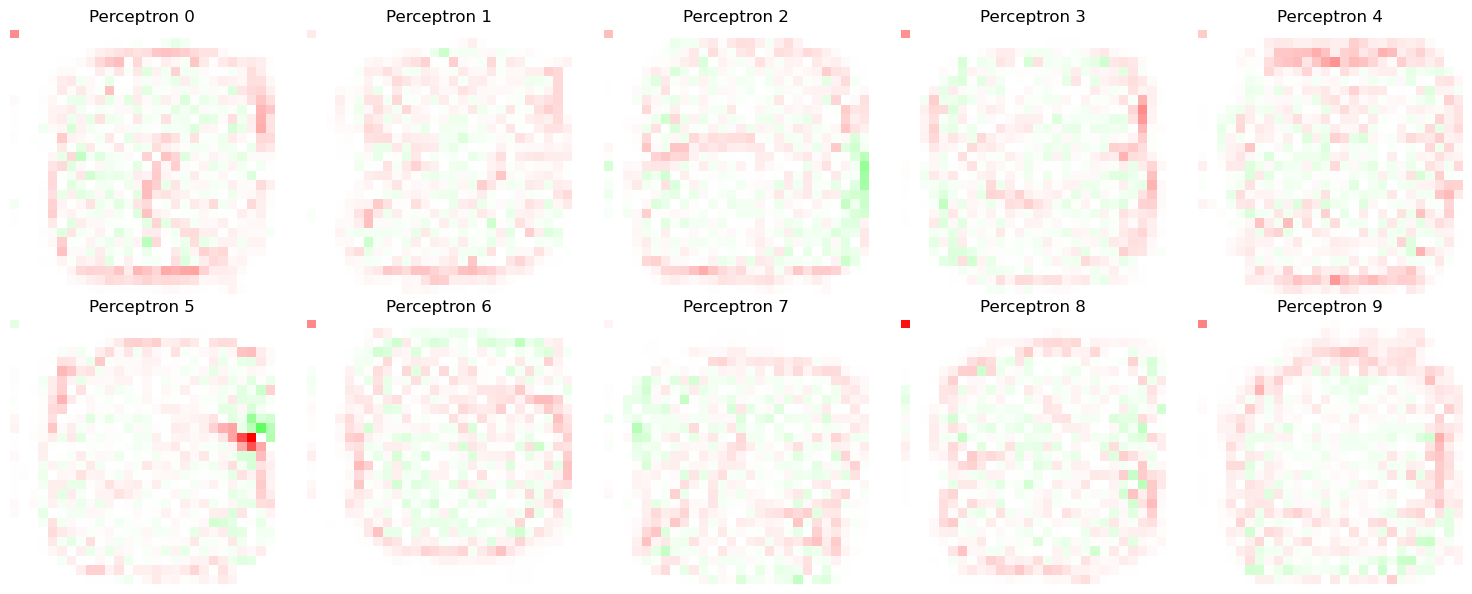

In [190]:
def plot_weight_vectors(weight_vectors):
    num_classes, num_features = weight_vectors.shape
    num_rows = 2
    num_cols = num_classes // num_rows
    cmap_colors = [(1, 0, 0), (1, 1, 1), (0, 1, 0)] 
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

    for i in range(num_rows):
        for j in range(num_cols):
            perceptron_index = i * num_cols + j
            if perceptron_index >= num_classes:
                break

            ax = axes[i, j]
            weight_image = weight_vectors[perceptron_index, :-1].reshape(28, 28)
            ax.imshow(weight_image, cmap=custom_cmap, vmin=-np.max(np.abs(weight_vectors)), vmax=np.max(np.abs(weight_vectors)))
            ax.set_title(f'Perceptron {perceptron_index}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_weight_vectors(P.vectors)

### PCA
#### Here, i used pca to try and plot all instances on a two dimentional plane. we can clearly see that some instances are easier to differentiate from one another. this of course doesnt provide us with the full image, because the data has much more dimentions than that. 

/var/folders/_m/bxqt90pd1vvfzd4y2lzs02ym0000gn/T/ipykernel_62765/1169947847.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  slope = -weights_pca[0] / weights_pca[1]
/var/folders/_m/bxqt90pd1vvfzd4y2lzs02ym0000gn/T/ipykernel_62765/1169947847.py:16: RuntimeWarning: invalid value encountered in scalar divide
  intercept = -bias / weights_pca[1]


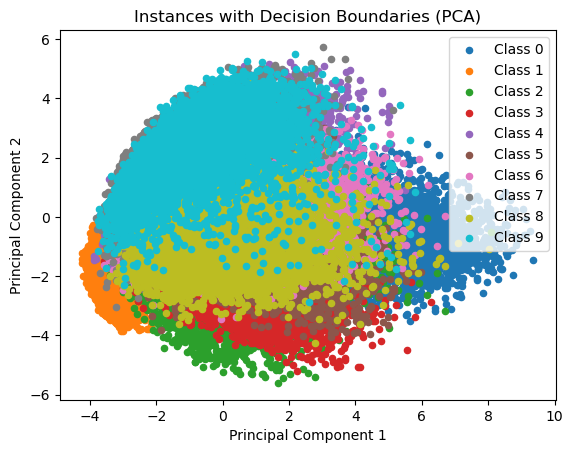

In [191]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)

x_margin = 0.1 * (X_pca[:, 0].max() - X_pca[:, 0].min())
y_margin = 0.1 * (X_pca[:, 1].max() - X_pca[:, 1].min())

for class_label in range(10):
    class_indices = np.where(y == class_label)
    plt.scatter(X_pca[class_indices, 0], X_pca[class_indices, 1], label=f'Class {class_label}', s=20)

for i, perceptron in enumerate(P.perceptrons):
    weights_pca = perceptron.weight_vector[:2] 
    bias = perceptron.weight_vector[-1]  

    slope = -weights_pca[0] / weights_pca[1]
    intercept = -bias / weights_pca[1]
    x_vals = np.linspace(X_pca[:, 0].min() - x_margin, X_pca[:, 0].max() + x_margin, 100)
    y_vals = slope * x_vals + intercept

    plt.plot(x_vals, y_vals, linestyle='--', linewidth=2)

plt.legend()
plt.title('Instances with Decision Boundaries (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


### Summing up
#### First of all I would like to say that i had a lot of fun working on the perceptron, that wasnt an easy task but I learned a lot.
#### The perceptron I built reached accuracy of ~88% which is, for my opinion very impressive. As we know, the perceptron can reach 100% iff the data is linearly separable, in our case, it is not.
#### A point that surprised me with this model, is its fast convergence. after 3-4 epochs the model yield very good results.  